In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

import inputools.Trajectory as it
from tools.evolutions import load_best_individual
import src.models as mm
from src.models import logger
import src.visualizations as mv

from tools.utils import clf, tqdm_enumerate

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger()

2024-01-18 18:46:53 | 


## Input space

In [530]:
pcs = np.array([[0.25, 0.25], [0.75, 0.25], [0.5, 0.75]])
gauss = lambda x, tu, s: np.exp(-np.linalg.norm(
    x.reshape(-1, 2) - tu.reshape(-1, 1, 2), axis=2)**2 / s)
pcs_x = lambda x, w: gauss(x, pcs, 0.04) * w

space_box = it.make_whole_walk(dx=0.01)
space_pc = pcs_x(space_box, 1)
space_box.shape

(10201, 2)

In [531]:
space_box.shape

(10201, 2)

In [357]:
k = 8 * 19
print(space_pc[:, k:k+10], '\n')
print(np.exp(-(space_pc[:, k:k+10] - np.array([0.4, 0.05]).reshape(2, 1))**2))

[[0.63762815 0.60653066 0.52204578 0.40656966 0.2865048  0.18268352
  0.10539922 0.05502322 0.02599113 0.011109  ]
 [0.0042963  0.011109   0.02599113 0.05502322 0.10539922 0.18268352
  0.2865048  0.40656966 0.52204578 0.60653066]] 

[[0.94509754 0.95824201 0.98521521 0.99995684 0.98720145 0.95387137
  0.91686997 0.88779983 0.86946027 0.85964462]
 [0.99791335 0.99848863 0.99942374 0.99997477 0.99693563 0.98254914
  0.94560105 0.88060869 0.80025311 0.73364767]]


In [458]:
space_pc.shape

(3, 10201)

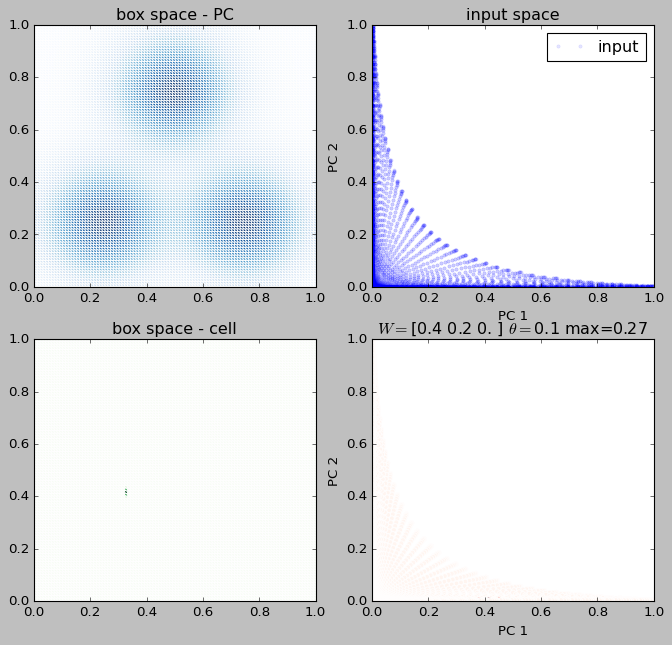

In [479]:
w = np.array([[0.4], [0.2], [0.]])
thr = 0.1
#cell_x = lambda x, thr: 1 / (1 + np.exp(-10*(x.sum(axis=0)-thr)))
#cell_x = lambda x, thr: 1 / (1 + np.exp(-6*(x.sum(axis=0)-thr)))
cell_x = lambda x, thr: 1 / (1 + np.exp(-10*(x-thr)))
#cell_x = lambda x, thr: 1*(x.sum(axis=0)>thr)

ds1 = space_pc.sum(axis=0)

space_pc_w = pcs_x(space_box, w)
#activation = cell_x(space_pc_w.sum(axis=0), thr)
activation = cell_x(np.exp(-np.linalg.norm(
    space_pc.reshape(-1, 3) - w.reshape(-1, 1, 3), axis=2) / 0.01).sum(axis=0),
                    thr)
#activation = cell_x(np.exp(-(space_pc - w)**2).prod(axis=0), thr)
#activation = cell_x(space_pc.T @ w, thr)

#activation[0] = 0.15

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9))

#
ax1.scatter(space_box[:, 0], space_box[:, 1], 
            c=space_pc.sum(axis=0), 
            cmap="Blues", edgecolors='white')

ax1.set_title("box space - PC")
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

#
ax2.plot(space_pc[0], space_pc[1], '.b', alpha=0.1, label='input')
ax2.set_title("input space")
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.legend(loc="upper right")

#
ax3.scatter(space_box[:, 0], space_box[:, 1], c=activation, 
            cmap="Greens", edgecolors='white')
#ax3.plot(activation[0], activation[1])
ax3.set_title("box space - cell")
ax3.set_xlim((0, 1))
ax3.set_ylim((0, 1))

#
#ax4.plot(activation[0], activation[1], '.r', alpha=0.01, label=f"w={w.flatten()}")
#ax4.plot(space_pc_w[0], space_pc_w[1], '.r', alpha=0.01, label=f"w={w.flatten()}")
#ax4.scatter(space_pc_w[0], space_pc_w[1], c=activation.flatten(), 
#            cmap='Greens', edgecolors='white', alpha=1.)
ax4.scatter(space_pc[0], space_pc[1], c=activation, 
            cmap='Reds', edgecolors='white', alpha=0.8)
ax4.set_title(f"$W=${w.flatten()} $\\theta=${thr} max={activation.max():.2f}")
ax4.set_xlim((0, 1))
ax4.set_ylim((0, 1))
ax4.set_xlabel("PC 1")
ax4.set_ylabel("PC 2")
#ax4.legend(loc="upper right")

plt.show()


## Hebbian

In [577]:
class Node:
    def __init__(self, Nj=3, lr=1e-2, u=0., noise=None):
        self.Nj = Nj
        self.w = np.zeros((1, Nj))
        self.lr = lr
        self.u = u
        self.a = 0.
        if not noise:
            self.noise = lambda: 0 
        else:
            self.noise = noise 
    
    def __call__(self, x, update=True, isnoise=True):
        self.u = self.w @ x + self.noise() * int(isnoise)
        self.a = 1 / (1 + np.exp(-20*(self.u - 1)))
        if update:
            self.w += self.lr * (self.a @ x.T - 0.3*self.w @ (x*x.T))

    def plotw(self, t, tper=10):
        if t % tper == 0:
            clf()
            plt.plot(range(self.Nj), self.w.flatten())
            plt.title(f"{t=} - {np.around(self.w.flatten(), 2)}")
            plt.ylim((0, 3))
            plt.grid()
            plt.pause(0.01)

def sample_is(model):
    """ visualized the model response in the input space """
    I = it.make_whole_walk(dx=0.01)
    A = np.zeros(len(I))
    for j, x in enumerate(I):
        model(x=x.reshape(-1, 1), update=False, isnoise=False)
        A[j] = model.a.item()

    plt.scatter(I[:, 0], I[:, 1], 
            c=A, cmap="Blues", edgecolors='white')
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()

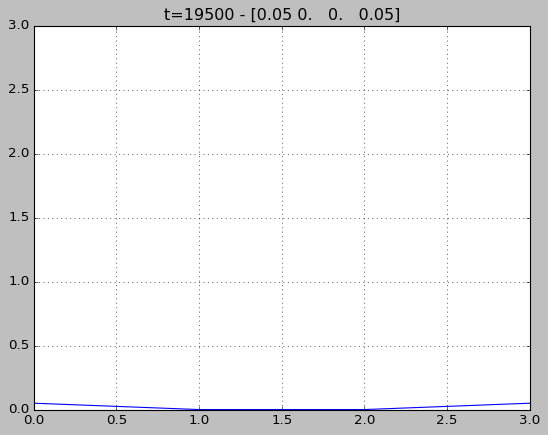

2024-01-16 17:33:37 | 


In [578]:
Nj = 4
T = 20*1000
I = np.zeros((Nj, T))
I[0] = 1
I[Nj-1] = 1.

node = Node(Nj=Nj, lr=0.01, u=0.01, noise=lambda: np.random.binomial(1, 0.05))

for t in range(T):
    node(x=I[:, t].reshape(-1, 1))
    node.plotw(t=t, tper=500)
        

logger()

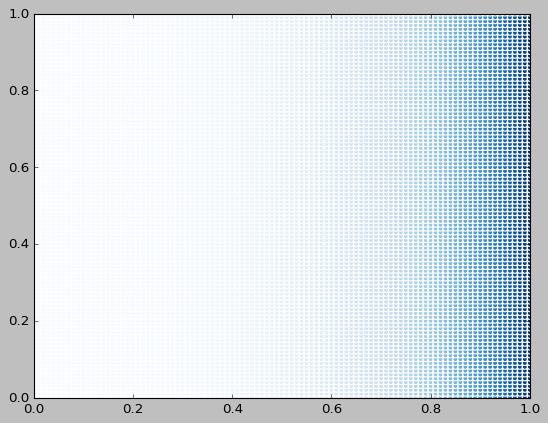

In [571]:
sample_is(node)

## Input II

In [270]:
it.make_patterned_input(N=5, T=30, Np=3, cycles=1, binary=False, size=2, seed=1)


array([[0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.4998081 , 0.32562489, 0.        , 0.        ],
       [0.        , 0.        , 0.37758215, 0.43394921, 0.        ],
       [0.        , 0.        , 0.37758215, 0.43394921, 0.        ],
       [0.        , 0.        , 0.37758215, 0.43394921, 0.        ],
       [0.        , 0.        , 0.37758215, 0.43394921, 0.        ],
       [0.        , 0.        , 0.

##### from evolution

In [20]:
record = load_best_individual()
genome = record['genome']
pprint(record)

2024-01-18 18:52:10 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2024-01-18 18:52:10 | 0: best_16_pcnn_d.json
2024-01-18 18:52:10 | 1: best_24_pcnn_d.json
2024-01-18 18:52:10 | 2: top_2311.json
2024-01-18 18:52:10 | 3: best_14_pcnn.json
2024-01-18 18:52:10 | 4: best_20.json
2024-01-18 18:52:10 | 5: best_12_pcnn.json
2024-01-18 18:52:10 | 6: best_28_pcnn_d.json
2024-01-18 18:52:10 | 7: top_2238.json
2024-01-18 18:52:10 | 8: best_21_pcnn_d.json
2024-01-18 18:52:10 | 9: best_29_pcnn_ptt.json
2024-01-18 18:52:10 | 10: best_8.json
2024-01-18 18:52:10 | 11: best_22_pcnn_d.json
2024-01-18 18:52:10 | 12: best_15_pcnn.json
2024-01-18 18:52:10 | 13: best_30_pcnn_ptt.json
2024-01-18 18:52:10 | 14: best_10.json
2024-01-18 18:52:10 | 15: best_19_pcnn_d.json
2024-01-18 18:52:10 | 16: best_13_pcnn.json
2024-01-18 18:52:10 | 17: best_11.json
2024-01-18 18:52:10 | 18: top_ij_1.json
2024-01-18 18:52:10 | 19: best_27_pcnn_d.json
2024-01-18 18:52:10 | 20: best_9.json
2024-01-18 18:52:10 |

Select a file index:  28


2024-01-18 18:52:21 | loaded `best_26_pcnn_d.json` from `/Users/daniekru/Research/lab/PCNN/cache`


{'genome': {'DA_tau': 3,
            'IS_magnitude': 2.6,
            'N': 5,
            'Nj': 5,
            'bias': 0.5,
            'bias_decay': 100,
            'bias_scale': 0.0,
            'dt': 1,
            'gain': 7.0,
            'is_retuning': False,
            'lr': 0.71071,
            'nb_per_cycle': 6,
            'nb_skip': 2,
            'plastic': True,
            'soft_beta': 15.5,
            'std_tuning': 0.0,
            'tau': 6,
            'theta_freq': 0.096,
            'theta_freq_increase': 0.3595250798719743,
            'wff_max': 2.2,
            'wff_min': 0.0,
            'wff_std': 0.0,
            'wff_tau': 1300},
 'info': {'data': {'dt': 0.1,
                   'duration': 5,
                   'k_average': 200,
                   'prob_turn': 0.004,
                   'sigma': 0.005,
                   'speed': [0.01, 0.01]},
          'date': '13/01/2024 at 19:39',
          'evolved': ['bias',
                      'lr',
                  

In [9]:
genome['lr'] = 0.3
genome['wff_max'] = 2.
genome['tau'] = 300

#### run

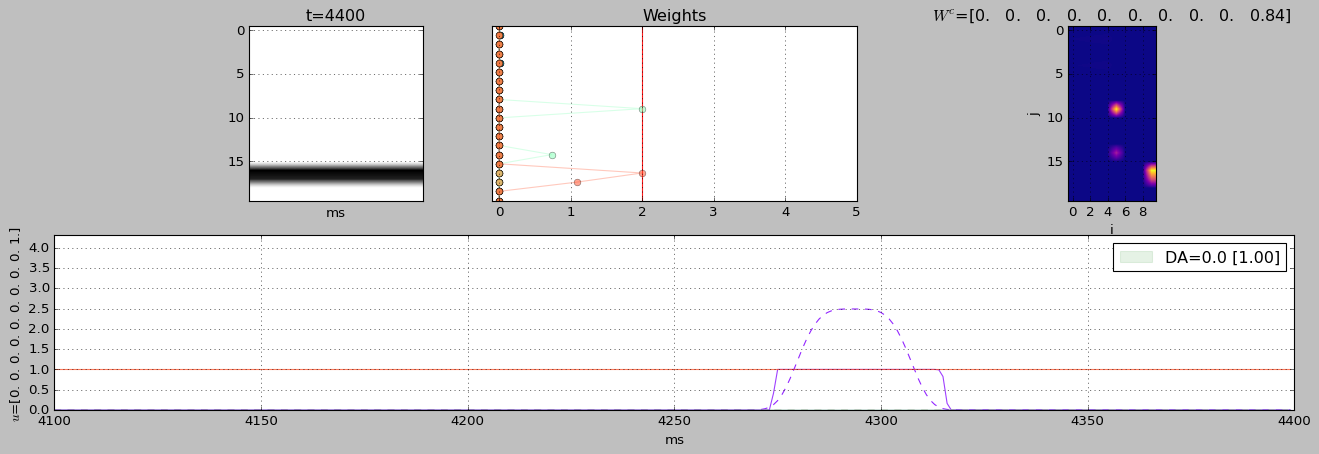

2024-01-18 18:41:27 | 


In [343]:
seed = None

genome = {
          'gain': 10.0,
          'bias': 1.1,
          'lr': 0.4,
          'tau': 700,
          'wff_std': 0.0,
          'wff_min': 0.0,
          'wff_max': 2.,
          'wff_tau': 1_000,
          'soft_beta': 2,
          'dt': 1,
          'N': 5,
          'Nj': 5,
          'DA_tau': 3,
          'bias_scale': 0.0,
          'bias_decay': 100,
          'IS_magnitude': 20,
          'theta_freq': 0.003,
          'nb_per_cycle': 5,
          'plastic': True,
          'nb_skip': 2,
          'seed': seed,
}

""" Initialization """

N, Nj = 10, 20
genome['N'] = N
genome['Nj'] = Nj
model = mm.PCNNetwork(**genome)

# select
inputs = it.make_patterned_input(N=Nj, T=3*1500, Np=3, cycles=1, binary=False, size=2, seed=seed)

""" Run """

record = np.zeros((N+1, len(inputs)))
Ix = np.zeros((N, len(inputs)))
X2 = np.zeros((len(inputs) + 10, Nj))
colors = [plt.cm.rainbow(i/N) for i in range(N)]

for t, x in enumerate(inputs):
  
    model.step(x=x.reshape(-1, 1))
    record[1:, t] = model.u.flatten()
    record[0, t] = model.DA
    Ix[:, t] = model.Is.flatten() / 8
    
    X2[10:t+10] = inputs[:t]

    if t % 100 == 0:
        mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors, subtitle_2=f"$W^c$={np.around(model.Ix.flatten(), 2)}")            
    
logger()

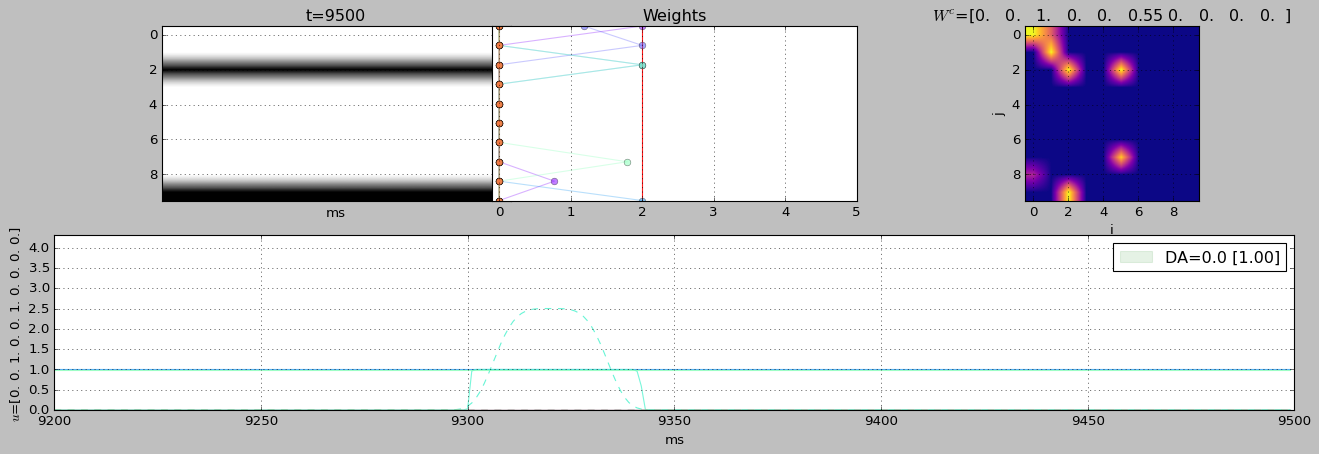

2024-01-18 18:53:48 | 


In [23]:
seed = None

genome = {
          'gain': 10.0,
          'bias': 1.1,
          'lr': 0.4,
          'tau': 700,
          'wff_std': 0.0,
          'wff_min': 0.0,
          'wff_max': 2.,
          'wff_tau': 1_000,
          'soft_beta': 1,
          'dt': 1,
          'N': 5,
          'Nj': 5,
          'DA_tau': 3,
          'bias_scale': 0.0,
          'bias_decay': 100,
          'IS_magnitude': 20,
          'theta_freq': 0.003,
          'nb_per_cycle': 5,
          'plastic': True,
          'nb_skip': 2,
          'seed': seed,
}

""" Initialization """

N, Nj = 10, 10
genome['N'] = N
genome['Nj'] = Nj
model = mm.PCNNetwork(**genome)

# select
inputs = it.make_patterned_input(N=Nj, T=5*2000, Np=5, cycles=1, binary=False, size=2, seed=seed)

""" Run """

record = np.zeros((N+1, len(inputs)))
Ix = np.zeros((N, len(inputs)))
X2 = np.zeros((len(inputs) + 10, Nj))
colors = [plt.cm.rainbow(i/N) for i in range(N)]

for t, x in enumerate(inputs):
  
    model.step(x=x.reshape(-1, 1))
    record[1:, t] = model.u.flatten()
    record[0, t] = model.DA
    Ix[:, t] = model.Is.flatten() / 8
    
    X2[10:t+10] = inputs[:t]

    if t % 500 == 0:
        mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors, subtitle_2=f"$W^c$={np.around(model.Ix.flatten(), 2)}")            
    
logger()

## Trajectory
---

In [4]:
def plot_activation(activation: np.ndarray, shape=None):

    size, N = activation.shape
    sqrtsize = int(np.sqrt(size))

    if shape is None:
        nr, nc = int(np.sqrt(N)), int(np.sqrt(N))
        shape = (nc, nr)
    else:
        nr, nc = shape

    _, axs = plt.subplots(nr, nc, figsize=(shape[1], shape[0]))
    i = 0
    for row in axs:
        for ax in row:
            ax.imshow(np.flip(activation[:, i].reshape(sqrtsize, sqrtsize), axis=0), cmap='plasma')
            ax.axis('off')
            i += 1
    plt.show()

2024-01-18 18:52:25 | Layer(N=36, kind=place)
2024-01-18 18:52:25 | Whole track, shape=(10201, 2)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10201/10201 [00:00<00:00, 124804.11it/s]
2024-01-18 18:52:25 | Trajectory shape=(4800, 2)


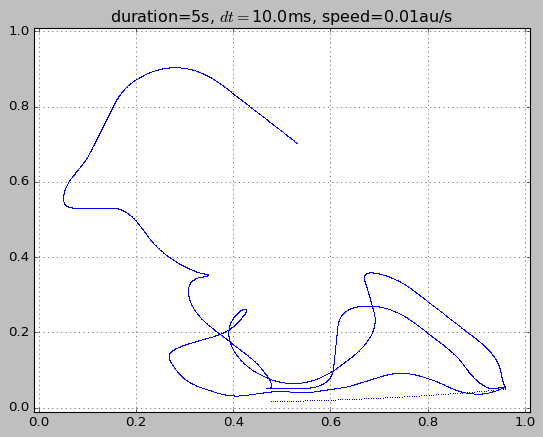

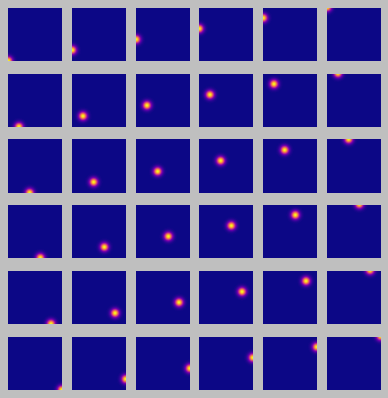

In [21]:
""" Initialization """
Nj = 36
duration = 5  # s
dt = 1e-2  # s
speed = 1e-2  # au/s

layer_pc = it.PlaceLayer(N=Nj, sigma=0.005)
#animal = it.AnimalTrajectory(dt=dt, 
#                             speed=speed,
#                             prob_turn=0.2)

#logger(animal)
logger(layer_pc)

""" Creation of the data """

#whole_track = it.AnimalTrajectory.whole_walk(dx=0.01)
whole_track = it.make_whole_walk(dx=0.01)

logger(f"Whole track, shape={whole_track.shape}")

# Create a trajectory
#trajectory = animal.make_trajectory(duration=duration, whole=False, dx=2, 
#                                    normalize=1, turning_scale=0.02)

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200)[200:]

inputs_pc = layer_pc.parse_trajectory(trajectory=trajectory)
whole_track_pc = layer_pc.parse_trajectory(trajectory=whole_track)

logger(f"Trajectory shape={trajectory.shape}")

""" Plot """
# trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], ',')
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.title(f"{duration=}s, $dt=${dt*1000}ms, speed={speed}au/s")
plt.show()

# activations
plot_activation(whole_track_pc)

**Training**

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10201/10201 [00:00<00:00, 27649.85it/s]


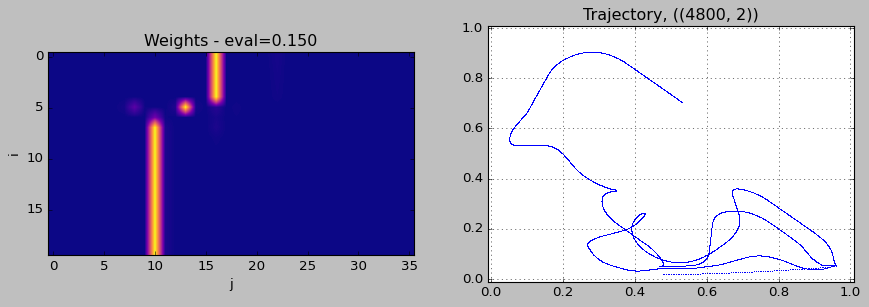

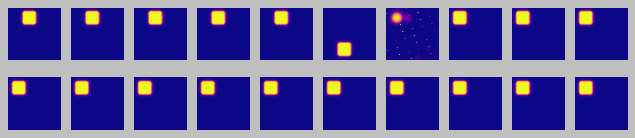

In [22]:
""" Initialization """
N = 20
genome['N'] = N
genome['Nj'] = Nj
genome['lr'] = 0.3
genome['wff_max'] = 2.
genome['tau'] = 400

model = mm.PCNNetwork(**genome)

""" Run """

# training
for t, x in tqdm_enumerate(inputs_pc):
    model.step(x=x.reshape(-1, 1))

""" Test """
record = np.empty((N, len(whole_track_pc)))
model._plastic = False
#model._bias = 1
#model._gain = 2
for t, x in tqdm_enumerate(whole_track_pc):
    model.step(x=x.reshape(-1, 1))   
    record[:, t] = model.u.flatten()

""" Plot """
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.imshow(model.Wff, cmap='plasma')
score = mm.eval_func(weights=model.Wff, wmax=model._wff_max, ignore_zero=False, axis=0)
plt.title(
 f"Weights - eval={score:.3f}")
plt.xlabel('j')
plt.ylabel('i')

plt.subplot(122)
plt.plot(trajectory[:, 0], trajectory[:, 1], ',')
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.title(f"Trajectory, ({trajectory.shape})")
plt.show()

plot_activation(record.T, shape=(2, 10))

In [16]:
""" test on the entire environment """
record = np.empty((N, len(whole_track_pc)))
model._plastic = False
model._bias = 2.5
model._gain = 1.
for t, x in tqdm_enumerate(whole_track_pc):
    model.step(x=x.reshape(-1, 1))   
    record[:, t] = model.u.flatten()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10201/10201 [00:00<00:00, 26600.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 88.71it/s]


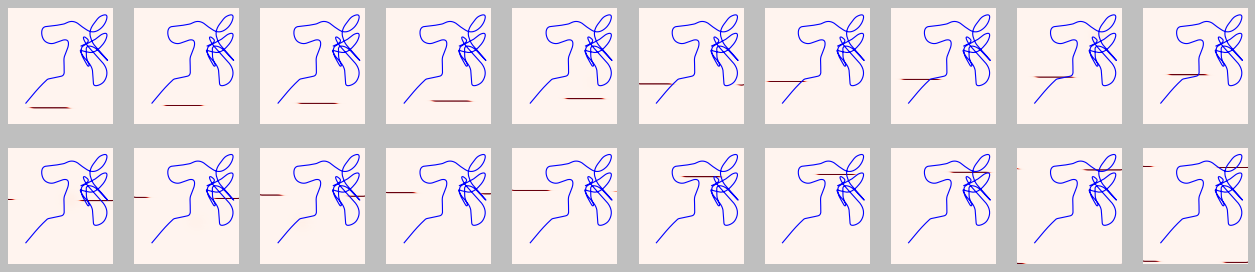

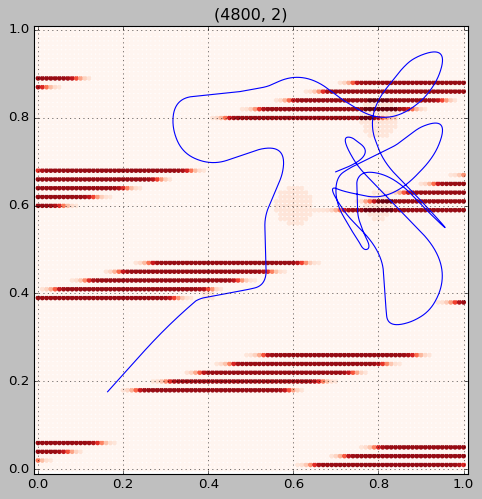

In [17]:
""" plot each cell's preferred location over the trajectory """

_, axs = plt.subplots(2, 10, figsize=(20, 4))
i = 0
for row in tqdm(axs):
    for ax in row:
        ax.plot(trajectory[:, 0], trajectory[:, 1])
        ax.scatter(whole_track[:, 0], whole_track[:, 1], c=record[i], s=100, cmap='Reds',
           edgecolors='black', linewidths=0)
        ax.axis('off')
        ax.set_ylim((-0.01, 1.01))
        ax.set_xlim((-0.01, 1.01))
        i += 1

plt.show()

""" plot all cells at the same time """

plt.figure(figsize=(7, 7))

plt.plot(trajectory[:, 0], trajectory[:, 1], '-b')

z = np.zeros(len(record[0]))
for i in range(N):
    z += np.where(record[i] > 0.1, record[i], 0)

#plt.scatter(whole_track[:, 0], whole_track[:, 1], c=record[7], s=20, cmap='Reds')
plt.scatter(whole_track[:, 0], whole_track[:, 1], c=z, s=20, cmap='Reds',
           edgecolors='black', linewidths=0)

plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.title(trajectory.shape)
plt.show()